In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import copy

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved waveforms

In [4]:
# trainset = ws.HDF5WaveformSet('../data/dh_training_set.hdf5')
# testset_rand = ws.HDF5WaveformSet('../data/dh_test_set_rand.hdf5')
# testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform.hdf5')

# trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015.hdf5')
#trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n1056.hdf5')
trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n50.hdf5')
len(trainset)

50

In [5]:
# params_rand = testset_rand.parameters()
# limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
# #kernel_type = 'matern52'

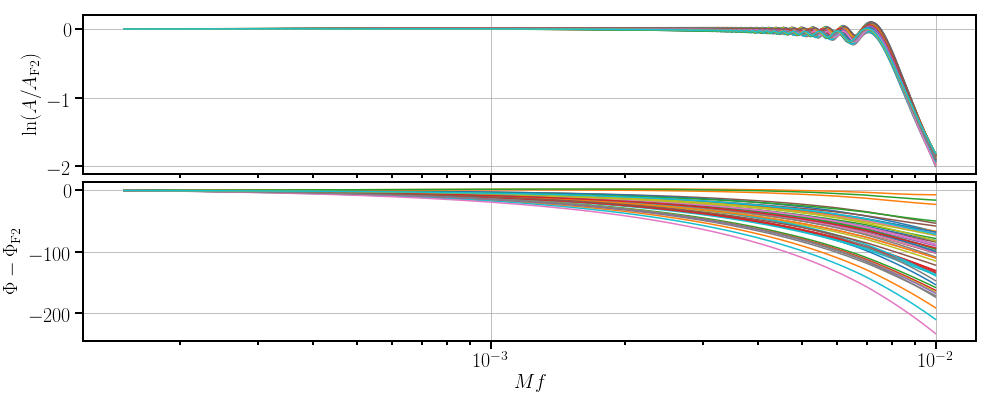

In [6]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Load surrogate model as well as the interpolating functions of (mf, params)

In [18]:
# Bamp_filename = '../data/Bamp_p00015.hdf5'
# Bphase_filename = '../data/Bphase_p00015.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

# Bamp_filename = '../data/Bamp_p00015_n1056.hdf5'
# Bphase_filename = '../data/Bphase_p00015_n1056.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015_n1056.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015_n1056.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

Bamp_filename = '../data/Bamp_p00015_n50.hdf5'
Bphase_filename = '../data/Bphase_p00015_n50.hdf5'
damp_gp_filename = '../data/amp_gp_p00015_n50.hdf5'
dphase_gp_filename = '../data/phase_gp_p00015_n50.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)


Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])

In [20]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

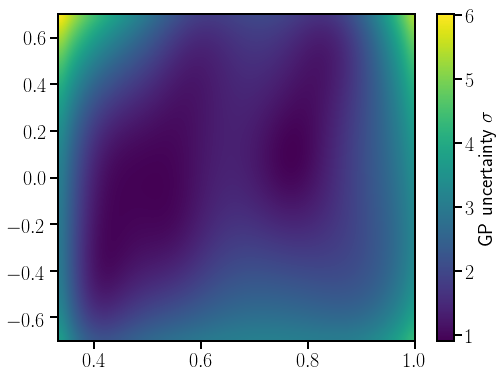

In [21]:
# print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
def gp_predict_error(x0, x1):
    i = 19
    return dphase_gp_list[i].predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
#plot_numbered_points(ax1, points)

0.00311363340872


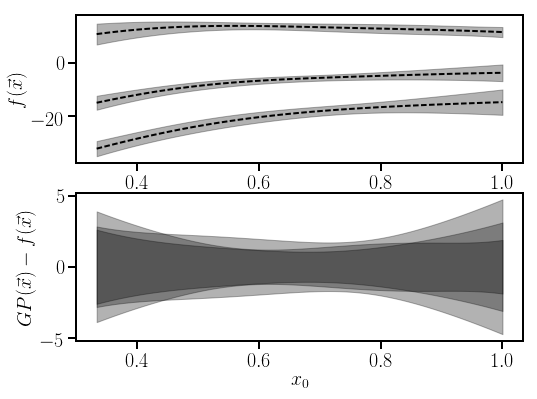

In [22]:
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
# ax[0].legend(bbox_to_anchor=(1.25, 1.05))
# ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Uncertainty sampling

In [23]:
def find_minimum(func, limits, nbasinjumps=20, nfun_eval_per_basin=15):
    """Find the minimum of func within the range given by limits.
    Uses basinhopping to jump between local minima, and 'L-BFGS-B' to find local minimum.
    The number of function evaluations will be approximately nbasinjumps*nfun_eval_per_basin.
    Features are rescaled from x\in[a, b] to xi\in[0, 1] before minimization.
    
    Parameters
    ----------
    """
    ######### Rescaling #########
    
    nparams = len(limits)
    xi_limits = np.array([[0., 1.]]*nparams)
    
    #xi0 = 0.5*np.ones(nparams)
    # Initial guess uniformly distributed in parameter space
    xi0 = np.random.uniform(low=0.0, high=1.0, size=nparams)
    
    points = []
    def func_scaled(xi):
        """Takes parameters from [0, 1] in each coordinate.
        """
        # Counter for function evaluations
        func_scaled.i += 1
        # Rescale each parameter to [a, b]
        x = np.array([(limits[i, 1]-limits[i, 0])*xi[i] + limits[i, 0] for i in range(nparams)])
        points.append(x)
        return func(x)
    
    def xi_boundary(**kwargs):
        """Return true or false.
        """
        xi = kwargs['x_new']
        # Test if xi is above 0
        tmin = bool(np.all(xi >= 0.0))
        # Test if xi is below 1
        tmax = bool(np.all(xi <= 1.0))
        # Test if xi is inside [0, 1] 
        inside = tmin and tmax
        return inside
    
    ######### Minimize func_scaled(xi) #########
    
    options={'maxfun':nfun_eval_per_basin}
    minimizer_kwargs = {'method':'L-BFGS-B', 'bounds':xi_limits, 'options':options}
    func_scaled.i = 0
    ret = optimize.basinhopping(
        func_scaled, xi0, niter=nbasinjumps, accept_test=xi_boundary, 
        minimizer_kwargs=minimizer_kwargs)
    
    f_min = ret.fun
    xi_min = ret.x
    x_min = np.array([(limits[i, 1]-limits[i, 0])*xi_min[i] + limits[i, 0] for i in range(nparams)])
    
    
    return x_min, f_min, np.array(points), func_scaled.i

In [24]:
def trapezoid_rule(xs, ys):
    """Use trapezoid rule to integrate between [xs[0], xs[-1]].
    xs don't have to be evenly spaced.
    """
    dxs = xs[1:] - xs[:-1]
    return np.sum(0.5*(ys[:-1]+ys[1:])*dxs)

In [25]:
def objective_function(point, dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, mfs_amp, mfs_phase, mf_0):
    """Objective function to minimize when searching for new training set points.
    This function provides an estimate of the error.
    Currently using the distinguishability with whitened psd.
    
    Parameters
    ----------
    point : n-d array
        Point x in parameter space to evaluate.
    dlnamp_gp_list :
        List of GPR functions for evaluating Deltaln(A(F_j; x) at the empirical nodes F_j
    sigma_dlnamp_gp_list :
        List of GPR functions for evaluating sigma_Deltaln(A).
        This is not the same as dlnamp_gp_list, because it gets updated, and the data can be anything.
    sigma_dphase_gp_list :
        List of GPR functions for evaluating sigma_DeltaPhi.
    mfs_amp : array
        Frequencies MF_j for the amplitude empirical nodes.
    mfs_phase : array
        Frequencies for the phase empirical nodes.
    mf_0 : Starting frequency where DeltaPhi is 0 (!!! but Deltaln(A) is not !!! This is a slight error.)
    """
    
    namp = len(sigma_dlnamp_gp_list)
    nphase = len(sigma_dphase_gp_list)
    
    # Calculate waveform at nodes
    dlnamp = np.array([dlnamp_gp_list[j].predict(np.atleast_2d(point), return_std=False)[0] 
                             for j in range(namp)])
    sigma_dlnamp = np.array([sigma_dlnamp_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                             for j in range(namp)])
    sigma_dphase = np.array([sigma_dphase_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                               for j in range(nphase)])
    
    ### !!!!!!!!!!!!! This is wrong. You can't just multiply amplitude and phase quantities together
    ### because they occur at different frequencies. This will also fail if you have a different
    ### number of amplitude and phase bases. !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    integrand_amp = sigma_dlnamp**2 * mfs_amp**(-7.0/3.0) * np.exp(2.0*dlnamp)
    #integrand_phase = sigma_dphase**2 * mfs_phase**(-7.0/3.0) * np.exp(2.0*dlnamp)
    integrand_phase = sigma_dphase**2 * mfs_phase**(-7.0/3.0)
    
    # Add the point at the beginning of the waveform when the error is zero
    mfs_amp = np.insert(mfs_amp, 0, mf_0)
    mfs_phase = np.insert(mfs_phase, 0, mf_0)
    integrand_amp = np.insert(integrand_amp, 0, 0.0)
    integrand_phase = np.insert(integrand_phase, 0, 0.0)
    dh_dot_dh = 4.0*(trapezoid_rule(mfs_amp, integrand_amp) + trapezoid_rule(mfs_phase, integrand_phase))
    return np.sqrt(dh_dot_dh)



# def objective_function(point, dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, mfs_amp, mfs_phase, mf_0):
#     """Objective function to minimize when searching for new training set points.
#     This function provides an estimate of the error.
#     Currently using the distinguishability with whitened psd.
#     """
    
#     namp = len(sigma_dlnamp_gp_list)
#     nphase = len(sigma_dphase_gp_list)
    
#     # Calculate waveform at nodes
#     sigma_dphase = np.array([sigma_dphase_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
#                                for j in range(nphase)])
    
#     return np.sqrt(np.sum(sigma_dphase**2))

In [47]:
def sample_new_point_with_fixed_hyperparameters(
    points, limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, 
    nsamples=100):
    """Get new point using uncertainty sampling.
    The points are needed but the data is not, because the GPR uncertainty
    does not depend on the data.

    Parameters
    ----------
    points : 2d array (npoints, ndim).
        Coordinates of sampled data.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    kernel_type : 'squaredexponential', 'matern32', 'matern52'
    dlnamp_gp_list :
        List of GPR functions for evaluating Deltaln(A(F_j; x) at the empirical nodes F_j
    dlnamp_hp_list : 
        Hyperparameters for dlnamp_list functions.
        Order is (sigma_f, ls_0, ls_1, ..., sigma_n).
    dlnamp_hp_list : 1d array (ndim+2,)
        Hyperparameters for dphase_list functions.
        mfs_amp : array
        Frequencies MF_j for the amplitude empirical nodes.
    mfs_phase : array
        Frequencies for the phase empirical nodes.
    mf_0 : Starting frequency where DeltaPhi is 0 (!!! but Deltaln(A) is not !!! This is a slight error.)     
    nsamples : int
        number of random points to search for largest GPR uncertainty.

    Returns
    -------
    point_new : The new point
    err_new : Estimate of the error at the new point.
        This should be ~max error over the parameter space.
    """
    namp = len(dlnamp_hp_list)
    nphase = len(dphase_hp_list)
    
    # Make fake data
    data = np.ones(len(points))

    # Generate GPR at each amplitude node
    sigma_dlnamp_gp_list = []
    for j in range(namp):
        hp = dlnamp_hp_list[j]
        gp = gpr.generate_gp(points, data, hp, fixed=True, kernel_type=kernel_type)
        sigma_dlnamp_gp_list.append(gp)
        
    # Generate GPR at each phase node
    sigma_dphase_gp_list = []
    for j in range(nphase):
        hp = dphase_hp_list[j]
        gp = gpr.generate_gp(points, data, hp, fixed=True, kernel_type=kernel_type)
        sigma_dphase_gp_list.append(gp)
        
    # ******* Perform uncertainty sampling *******
    
#     # --Find the point with the maximum uncertainty given the current Gaussian process.
#     # --For now use Monte Carlo sampling.
#     # --Later, do a multistart optimization.
#     test_points = doe.uniform_random_samples(nsamples, limits)
    
#     test_errs = np.array([objective_function(
#         p, 
#         dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, 
#         mfs_amp, mfs_phase, mf_0) for p in test_points])
    
#     i_max = np.argmax(test_errs)
#     point_new = test_points[i_max]
#     err_new = test_errs[i_max]
    
    def neg_objective(p):
        return -objective_function(
            p, 
            dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, 
            mfs_amp, mfs_phase, mf_0)
    
    point_new, fmin, points, neval = find_minimum(neg_objective, limits, nbasinjumps=100, nfun_eval_per_basin=15)
    err_new = -fmin
    print neval, err_new, point_new
    return point_new, err_new

In [48]:
def sample_n_new_points_with_fixed_hyperparameters(
    n_new, points, 
    limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, nsamples=100):
    """Get n_new new points.
    """
    points_updated = copy.copy(points)
    error_list = []
    for i in range(n_new):
        print i,
        # Find the best location for the new point
        point_new, error_new = sample_new_point_with_fixed_hyperparameters(
            points_updated, 
            limits, kernel_type, 
            dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
            mfs_amp, mfs_phase, mf_0, nsamples=nsamples)

        # Add the new point to the list of updated points
        points_updated = np.concatenate((points_updated, np.atleast_2d(point_new)))
        error_list.append(error_new)
    # Return just the new points that you added
    return points_updated[-n_new:], np.array(error_list)

In [39]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015

print objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

%timeit objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

188.793953948
100 loops, best of 3: 10.4 ms per loop


In [40]:
# def mismatch_error(point):
#     return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

# x0 = np.array([0.6, 0.1, 0.2, 4000., 4000.])
# optimize.basinhopping(
#     mismatch_error, x0, niter=10, T=1.0, stepsize=0.5, 
#     minimizer_kwargs=None, take_step=None, accept_test=None, 
#     callback=None, interval=50, disp=False, niter_success=None)

In [41]:
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015
nsamples=200

In [49]:
point_new, err_new = sample_new_point_with_fixed_hyperparameters(
    points, limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, 
    nsamples=nsamples)

point_new, err_new

1188 819.793973292 [  1.00000000e+00   7.00000000e-01  -7.00000000e-01   1.00000000e+04
   0.00000000e+00]


(array([  1.00000000e+00,   7.00000000e-01,  -7.00000000e-01,
          1.00000000e+04,   0.00000000e+00]), 819.79397329219341)

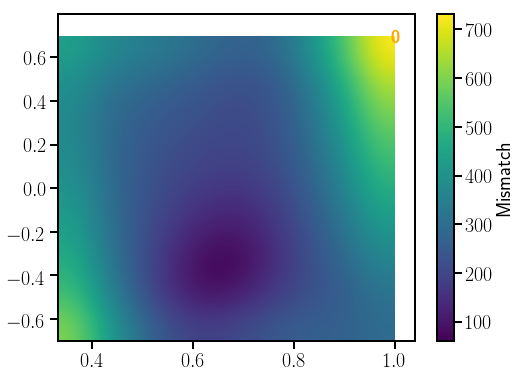

In [43]:
#x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
# x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'Mismatch')
plot_numbered_points(ax1, np.array([point_new]))

In [59]:
n_new = 200
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015
nsamples=1000

points_new, errors_new = sample_n_new_points_with_fixed_hyperparameters(
    n_new, points, 
    limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, nsamples=nsamples)

0 1188 819.793973292 [  1.00000000e+00   7.00000000e-01  -7.00000000e-01   1.00000000e+04
   0.00000000e+00]
1 1194 721.820947843 [ 1.   0.7  0.7  0.   0. ]
2 1230 722.713414877 [ 0.33333333  0.7         0.7         0.          0.        ]
3 1254 635.431371828 [  3.33333333e-01  -7.00000000e-01  -7.00000000e-01   0.00000000e+00
   1.00000000e+04]
4 1470 572.60730723 [  1.00000000e+00  -7.00000000e-01   7.00000000e-01   1.00000000e+04
   0.00000000e+00]
5 1188 662.147747959 [  3.33333333e-01   7.00000000e-01  -7.00000000e-01   1.00000000e+04
   1.00000000e+04]
6 1224 606.451010967 [  1.00000000e+00   7.00000000e-01  -7.00000000e-01   1.00000000e+04
   1.00000000e+04]
7 1272 568.920876367 [  3.33333333e-01   7.00000000e-01   7.00000000e-01   0.00000000e+00
   1.00000000e+04]
8 1326 532.291179133 [ 0.33333333 -0.7         0.7         0.          0.        ]
9 1314 537.380150201 [ 1.   0.7 -0.7  0.   0. ]
10 1224 506.40839862 [  1.00000000e+00   7.00000000e-01   7.00000000e-01   1.00000000

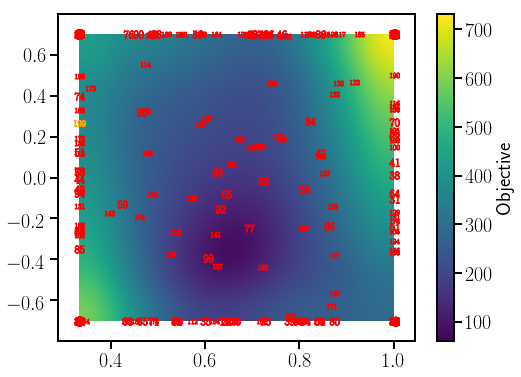

In [60]:
#x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
# x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'Objective')
plot_numbered_points(ax1, points_new)

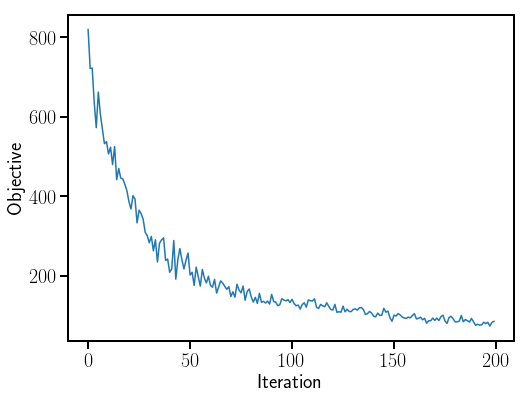

In [61]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(errors_new)
axes.set_xlabel('Iteration')
axes.set_ylabel('Objective')
#axes.set_ylim(0, 200)

In [62]:
points_errors = np.concatenate((points_new.T, np.array([errors_new]))).T
points_errors[:5, [0,5]]

array([[  1.00000000e+00,   8.19793973e+02],
       [  1.00000000e+00,   7.21820948e+02],
       [  3.33333333e-01,   7.22713415e+02],
       [  3.33333333e-01,   6.35431372e+02],
       [  1.00000000e+00,   5.72607307e+02]])

In [63]:
#np.savetxt('../data/new_points_errors_200_from_50.txt', points_errors)

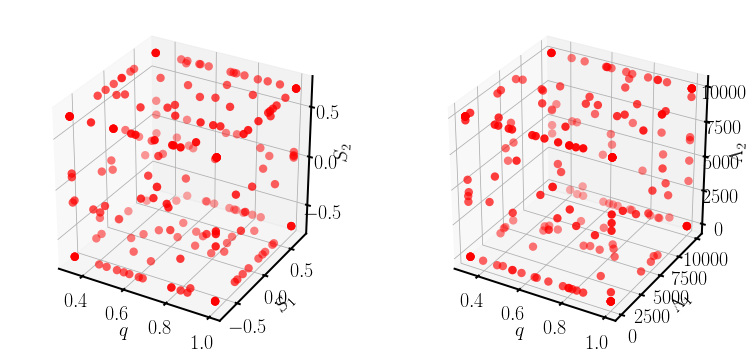

In [64]:
fig = plt.figure(figsize=(13, 6))

axes = fig.add_subplot(121, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 1], params[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$S_2$')

axes = fig.add_subplot(122, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 3], params[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$\Lambda_1$')
axes.set_zlabel('$\Lambda_2$')

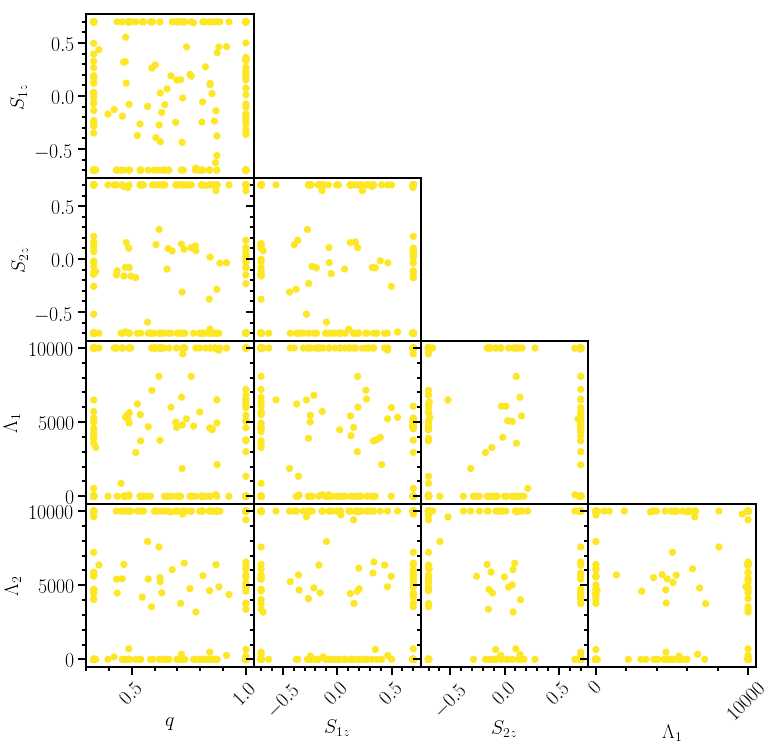

In [65]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = points_new
error = np.ones(len(params))
error[0]*=0.5
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))